<a href="https://colab.research.google.com/github/anovaes2002/active_learning/blob/main/Alexsander_Active_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tópicos Especiais em Machine Learning**

<b>Professor:</b> Dr. Gabriel Tozatto Zago <br>

<b>Aluno:</b> Alexsander Alves Novaes <br>
<b>Matrícula:</b> 20212mpeca0037<br>

**Active Learning** <br> 
<b>Prazo:</b> 30/11/2022

**Objetivo**: Aplicar Active Learning num banco de dados para demonstrar que o treinamento de um modelo utilizando esta técnica, mesmo utilizando menos dados, atinge resultados melhores do que o mesmo modelo utilizando dados amostrados aleatoriamente com a mesma quantidade de amostras.

O resultado deve gerar um gráfico parecido com o da figura abaixo.: <br>
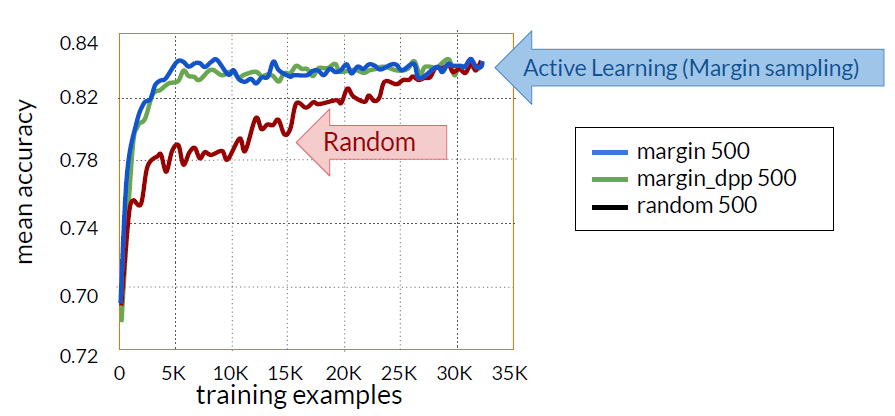

Entregáveis:

Descrição do que foi feito <s>em formato de artigo científico</s>: <br>
[Vídeo Explicativo no OneDrive](https://1drv.ms/v/s!AihxfjCJSCazsLATn29a1gNwWpetBw?e=5iGCvr) <br><br>
Link para o código no github: <br>
https://github.com/anovaes2002/active_learning/blob/main/Alexsander_Active_learning.ipynb <br>

In [1]:
#importando bibliotecas
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import re
import string

In [2]:
#Importando dataset imdb
# Usaremos o conjunto de dados de avaliações do IMDB para nossos experimentos.
# Este conjunto de dados tem 50.000 revisões no total, incluindo divisões de treinamento e teste. 
# Vamos mesclar essas divisões e amostrar nossos próprios conjuntos de treinamento, validação e teste balanceados.

dataset = tfds.load("imdb_reviews",
                    split         = "train + test",
                    as_supervised = True,
                    batch_size    = -1,
                    shuffle_files = False,)
reviews, labels = tfds.as_numpy(dataset)

print("Total examples:", reviews.shape[0])

Total examples: 50000


In [3]:
#Definindo o tamanho do dataset
val_split   =  2500
test_split  =  2500
train_split = 15000

# Separando as amostras negativas e positivas para estratificação manual
x_positives, y_positives = reviews[labels == 1], labels[labels == 1]
x_negatives, y_negatives = reviews[labels == 0], labels[labels == 0]

# Criação de divisões de treinamento, validação e teste
x_val, y_val = (
    tf.concat((x_positives[:val_split], x_negatives[:val_split]), 0),
    tf.concat((y_positives[:val_split], y_negatives[:val_split]), 0),
)
x_test, y_test = (
    tf.concat(
        (
            x_positives[val_split : val_split + test_split],
            x_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split : val_split + test_split],
            y_negatives[val_split : val_split + test_split],
        ),
        0,
    ),
)
x_train, y_train = (
    tf.concat(
        (
            x_positives[val_split + test_split : val_split + test_split + train_split],
            x_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
    tf.concat(
        (
            y_positives[val_split + test_split : val_split + test_split + train_split],
            y_negatives[val_split + test_split : val_split + test_split + train_split],
        ),
        0,
    ),
)

# O conjunto restante de amostras é armazenado separadamente. 
# Estes são rotulados apenas como e quando necessário
x_pool_positives, y_pool_positives = (
    x_positives[val_split + test_split + train_split :],
    y_positives[val_split + test_split + train_split :],
)
x_pool_negatives, y_pool_negatives = (
    x_negatives[val_split + test_split + train_split :],
    y_negatives[val_split + test_split + train_split :],
)

# Criação de conjuntos de dados para pré-busca e paralelização mais rápidas
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

pool_negatives = tf.data.Dataset.from_tensor_slices((x_pool_negatives, y_pool_negatives))
pool_positives = tf.data.Dataset.from_tensor_slices((x_pool_positives, y_pool_positives))

# Criação de Dataset Unlabel
unlabel_dataset = (
    pool_positives
    .concatenate(pool_negatives)
    .cache()
    .shuffle(5000)
)

# Criação de Dataset FULL com somatorio de treino e pool
full_train_dataset = (
    train_dataset.concatenate(pool_positives)
    .concatenate(pool_negatives)
    .cache()
    .shuffle(20000)
)

In [4]:
# Imprime tamanho dos datasets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabeled negative pool: {len(pool_negatives)}")
print(f"Unlabeled positive pool: {len(pool_positives)}")
print(f"Unlabel Dataset set size: {len(unlabel_dataset)}")
print(f"Full Train Dataset set size: {len(full_train_dataset)}")

Training set size: 30000
Validation set size: 5000
Testing set size: 5000
Unlabeled negative pool: 5000
Unlabeled positive pool: 5000
Unlabel Dataset set size: 10000
Full Train Dataset set size: 40000


In [5]:
# Como estamos trabalhando com dados de texto, precisaremos codificar as sequências de texto como vetores
# que serão passados ​​por uma camada de Embedding. 
# Para tornar esse processo de tokenização mais rápido, usamos a map()função com sua funcionalidade de paralelização.

# Para tratar os textos
def custom_standardization(input_data):
    lowercase     = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

# Vetorização dos textos
vectorizer = layers.TextVectorization(3000, standardize=custom_standardization, output_sequence_length=150)

# Adaptando o dataset
vectorizer.adapt(train_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE).batch(256))

# Para vetorizar sequencia de texto
def vectorize_text(text, label):
    text = vectorizer(text)
    return text, label

# Para redimensionar o dataset dividindo por 100
def batch_dataset(dataset):
    ds = dataset.batch(100)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


In [6]:
#Aplicando a vetorização nos datasets
train_dataset       = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
pool_negatives      = pool_negatives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
pool_positives      = pool_positives.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
full_train_dataset  = full_train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
unlabel_dataset     = unlabel_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

#Reduzindo o tamanho dos datasets val e test
val_dataset  = val_dataset.batch(16).map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(16).map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
#Imprime o tamanho atualizado dos datasets
print(f"Full Train dataset size: {len(full_train_dataset)}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")
print(f"Unlabeled negative pool size: {len(pool_negatives)}")
print(f"Unlabeled positive pool size: {len(pool_positives)}")
print(f"Unlabel dataset size: {len(unlabel_dataset)}")

Full Train dataset size: 40000
Training dataset size: 30000
Validation dataset size: 313
Testing dataset size: 313
Unlabeled negative pool size: 5000
Unlabeled positive pool size: 5000
Unlabel dataset size: 10000


In [8]:
#Épocas de treinamento
epochs = 20

In [9]:
#Definindo o modelo
model = keras.models.Sequential(
    [
        layers.Input(shape=(150,)),
        layers.Embedding(input_dim=3000, output_dim=128),
        layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
        layers.GlobalMaxPool1D(),
        layers.Dense(20, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          384000    
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          41216     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [10]:
model.compile(
    loss      = "binary_crossentropy",
    optimizer = "rmsprop",
    metrics   = "accuracy")

In [11]:
#Para mostrar a eficácia do Active Learning, vamos primeiro treinar o modelo em todo o conjunto de dados contendo 40000 amostras. 
#Este modelo será utilizado para comparação posteriormente.

history1  = model.fit(
    full_train_dataset.batch(32),
    epochs          = epochs,
    validation_data = val_dataset)

Epoch 1/20
1250/1250 [==============================] - 30s 20ms/step - loss: 0.4236 - accuracy: 0.8112 - val_loss: 0.3461 - val_accuracy: 0.8438
Epoch 2/20
1250/1250 [==============================] - 24s 19ms/step - loss: 0.3320 - accuracy: 0.8660 - val_loss: 0.3185 - val_accuracy: 0.8654
Epoch 3/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.3027 - accuracy: 0.8798 - val_loss: 0.3092 - val_accuracy: 0.8716
Epoch 4/20
1250/1250 [==============================] - 25s 20ms/step - loss: 0.2770 - accuracy: 0.8896 - val_loss: 0.3037 - val_accuracy: 0.8706
Epoch 5/20
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2538 - accuracy: 0.9006 - val_loss: 0.3129 - val_accuracy: 0.8682
Epoch 6/20
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2316 - accuracy: 0.9109 - val_loss: 0.3101 - val_accuracy: 0.8690
Epoch 7/20
1250/1250 [==============================] - 22s 18ms/step - loss: 0.2084 - accuracy: 0.9213 - val_loss: 0.3366 -

In [12]:
# Predições
# Carregando o modelo já treinado
prediction_model  = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# Realiza as predições do dataset unlabel
prediction_unlabel = [prediction_model.predict(batch_unlabels)
              for batch_unlabels, batch_labels in batch_dataset(unlabel_dataset)]

# Concatena os dados retornados na linha anterior
prediction = np.concatenate(prediction_unlabel)

4/4 [==============================] - 0s 7ms/step


In [13]:
# Calculando a probabilidade máxima para cada amostra de acordo com o dataset não rotulado, 
# e selecionando as amostras com os menores valores até que a quantidade total em "budget" seja selecionada.

# Melhores resultados
bests_results = prediction.max(axis=1)

# Quantidade de dados a selecionar
target = 100

# Ordenando os índices
index_order = np.argsort(bests_results)[:target]

In [14]:
# Unindo os dados do dataset unlabel
unlabels, labels = tuple(zip(*unlabel_dataset))

# Dados escolhidos baseados nas probabilidades menores
unlabels_small = np.array(unlabels)[index_order]

# Labels escolhidos baseados nas probabilidades menores
labels_small = np.array(labels)[index_order]

# Criando a lista com seus labels
unlabel_dataset = tf.data.Dataset.from_tensor_slices((unlabels_small, labels_small))

In [15]:
# Novo dataset contendo os dados unlabel
# Agregando ao dataset dataset de treinamento redimensionado o dataset unlabel
new_train_dataset = train_dataset.concatenate(unlabel_dataset)

# Reduzindo o novo dataset de treinamento com o batch_dataset(100)
new_train_dataset = batch_dataset(new_train_dataset)

In [16]:
#listando o tamanho dos datasets
print("Total examples:", reviews.shape[0])
print(f"Training set size: {len(train_dataset)}")
print(f"New Train Dataset set size: {len(new_train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")
print(f"Unlabels set size: {len(unlabels)}")
print(f"Labels set size: {len(labels)}")
print(f"Unlabel Dataset set size: {len(unlabel_dataset)}")

Total examples: 50000
Training set size: 30000
New Train Dataset set size: 301
Validation set size: 313
Testing set size: 313
Unlabels set size: 10000
Labels set size: 10000
Unlabel Dataset set size: 100


In [17]:
#Treinando novamente agora com os datasets reduzidos
history2 = model.fit(new_train_dataset, 
                     validation_data = val_dataset, 
                     epochs          = epochs)

Epoch 1/20
301/301 [==============================] - 8s 27ms/step - loss: 0.0283 - accuracy: 0.9972 - val_loss: 1.7397 - val_accuracy: 0.8484
Epoch 2/20
301/301 [==============================] - 8s 26ms/step - loss: 0.0095 - accuracy: 0.9986 - val_loss: 2.0563 - val_accuracy: 0.8472
Epoch 3/20
301/301 [==============================] - 8s 27ms/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 2.7121 - val_accuracy: 0.8132
Epoch 4/20
301/301 [==============================] - 8s 26ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 2.8578 - val_accuracy: 0.8122
Epoch 5/20
301/301 [==============================] - 8s 28ms/step - loss: 0.0166 - accuracy: 0.9988 - val_loss: 5.7887 - val_accuracy: 0.7320
Epoch 6/20
301/301 [==============================] - 8s 26ms/step - loss: 0.0149 - accuracy: 0.9980 - val_loss: 4.3617 - val_accuracy: 0.7586
Epoch 7/20
301/301 [==============================] - 8s 26ms/step - loss: 0.0042 - accuracy: 0.9992 - val_loss: 4.3691 - val_accuracy: 0.7710

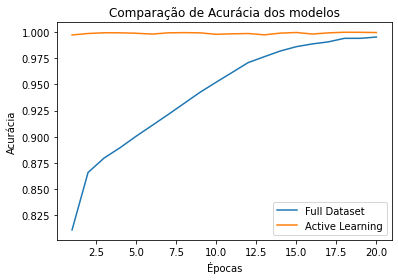

In [18]:
#Plotando as acurácias dos dois modelos
epochs_plot = np.arange(1, epochs + 1)
plt.plot(epochs_plot, history1.history['accuracy'], label = 'Full Dataset')
plt.plot(epochs_plot, history2.history['accuracy'], label = 'Active Learning')
plt.title('Comparação de Acurácia dos modelos')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()